In [1]:


import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt

## Load HPI Data from Excel

This section loads the House Price Index (HPI) data for US states from an Excel file.  
The data is used for all subsequent analysis and visualizations.

In [3]:
hpi_at_state_df = pd.read_excel("hpi_at_state.xlsx", skiprows=5)
print(hpi_at_state_df.head())


     State Abbreviation  FIPS  Year  Annual Change (%)     HPI  \
0  Alabama           AL     1  1975                NaN  100.00   
1  Alabama           AL     1  1976               8.21  108.21   
2  Alabama           AL     1  1977              10.35  119.41   
3  Alabama           AL     1  1978               7.90  128.85   
4  Alabama           AL     1  1979              10.88  142.87   

   HPI with 1990 base  HPI with 2000 base  
0               48.78               35.36  
1               52.79               38.26  
2               58.25               42.23  
3               62.85               45.56  
4               69.69               50.52  


## HPI by State (1990 Base)

This plot shows the House Price Index (HPI) for key states in the US, using a 1990 base year.  
Each line represents a different state, allowing for comparison of HPI trends over time.

- **States included:** CA, TX, NY, FL, PA, IL, OH, GA, NC
- **Data source:** `hpi_at_state.xlsx`
- **Visualization:** Interactive Bokeh line chart

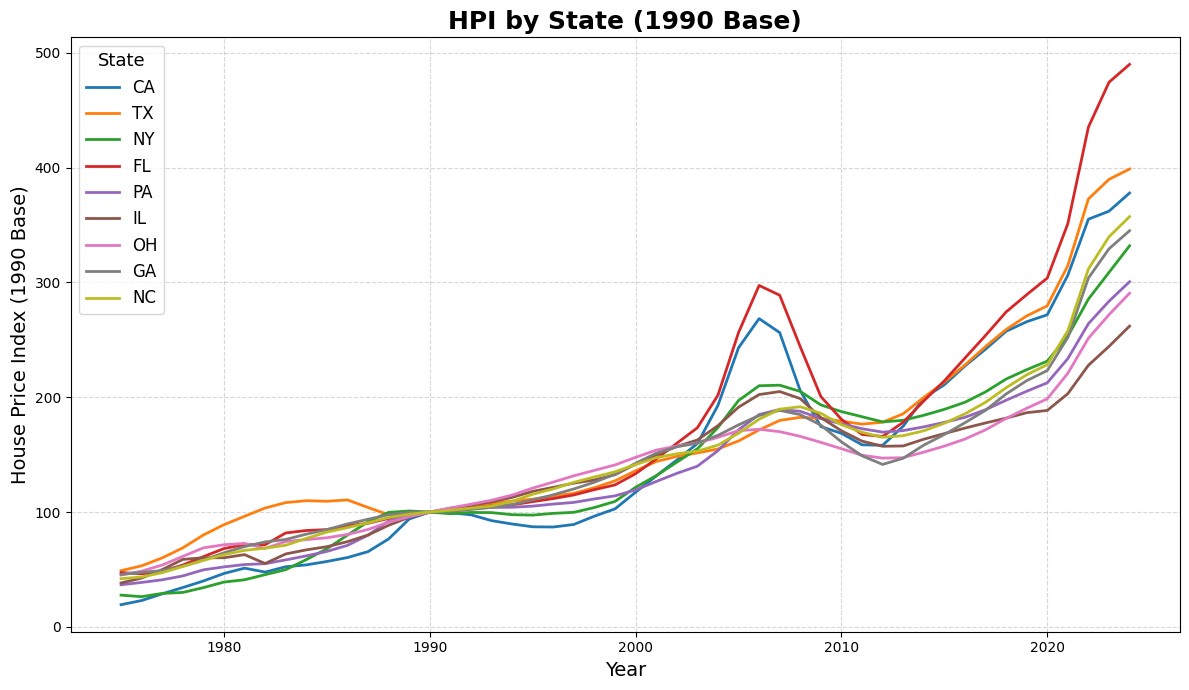

In [6]:


# Choose key states based on population and economic significance
key_states = ["CA", "TX", "NY", "FL", "PA", "IL", "OH", "GA", "NC", ]  

# Colors for lines


# Plot for HPI with 1990 base
plt.figure(figsize=(12, 7))
for state in key_states:
    state_data = hpi_at_state_df[hpi_at_state_df["Abbreviation"] == state]
    plt.plot(
        state_data["Year"], 
        state_data["HPI with 1990 base"], 
        label=state, 
        linewidth=2
    )
plt.title("HPI by State (1990 Base)", fontsize=18, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("House Price Index (1990 Base)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="State", fontsize=12, title_fontsize=13, loc="upper left", frameon=True)
plt.tight_layout()
plt.show()



## HPI by State (2000 Base)

This plot shows the House Price Index (HPI) for key states in the US, using a 2000 base year.  


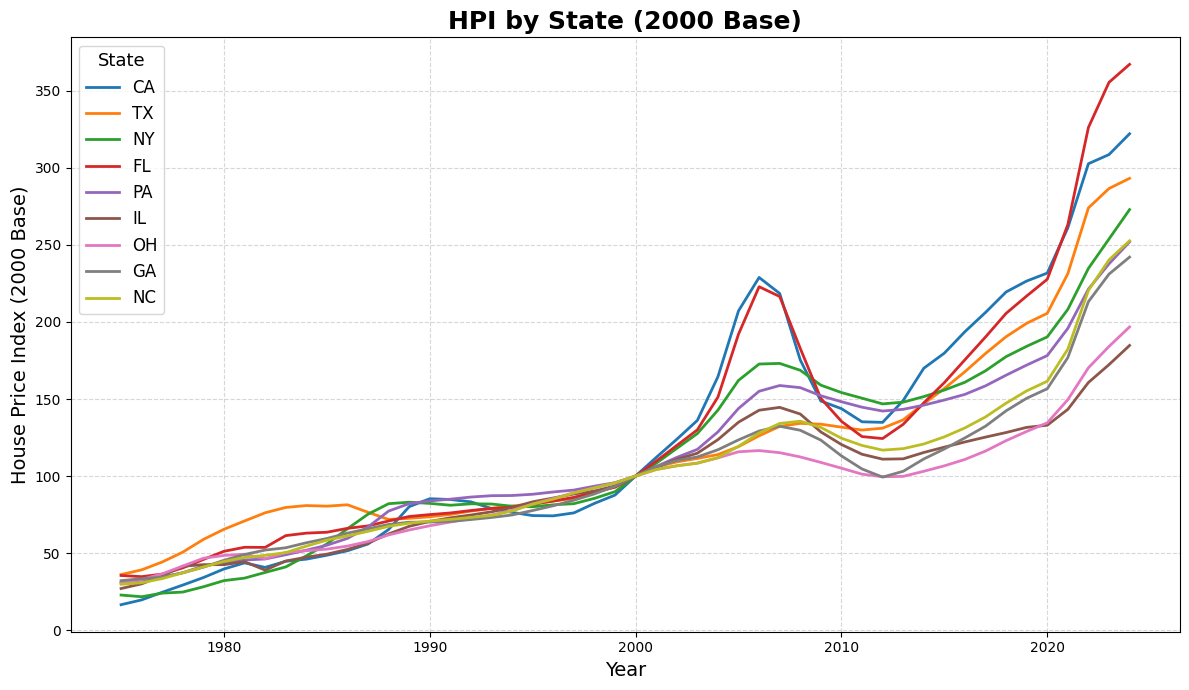

In [7]:
# Plot for HPI with 2000 base
plt.figure(figsize=(12, 7))
for state in key_states:
    state_data = hpi_at_state_df[hpi_at_state_df["Abbreviation"] == state]
    plt.plot(
        state_data["Year"], 
        state_data["HPI with 2000 base"], 
        label=state, 
        linewidth=2
    )
plt.title("HPI by State (2000 Base)", fontsize=18, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("House Price Index (2000 Base)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="State", fontsize=12, title_fontsize=13, loc="upper left", frameon=True)
plt.tight_layout()
plt.show()


## Correlation of HPI (1990 Base) Between States

This analysis computes and visualizes the correlation of House Price Index (HPI) values (using a 1990 base year) between key US states.  
The correlation matrix helps identify which states have similar housing price trends, which is useful for predictive modeling and understanding market relationships.
- **Visualization:** Seaborn heatmap



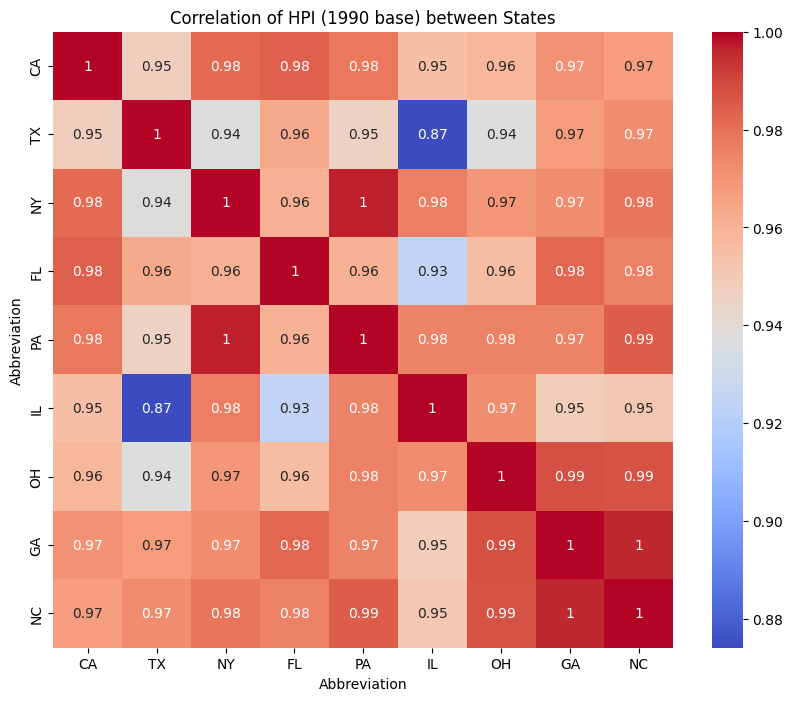

In [8]:
# Pivot the DataFrame so each state's HPI is a column
hpi_1990 = hpi_at_state_df.pivot(index="Year", columns="Abbreviation", values="HPI with 1990 base")
hpi_1990_key_states=hpi_1990[key_states]

# Compute the correlation matrix
correlation_matrix = hpi_1990_key_states.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation of HPI (1990 base) between States")
plt.show()

## State Pair Correlations (HPI 1990 Base)

The correlations shown in the Seaborn heatmap above are further processed here to create a horizontal bar chart for each unique state pair.  
Each bar represents the correlation value between two states' House Price Index (HPI) trends, using a 1990 base year.

These correlations help us identify which state pairs have the most similar housing market dynamics. In the next section, we will use this information to select the best state pairs as predictors when modeling or forecasting the HPI of another state.


- **Visualization:** Horizontal bar chart, one bar per state pair.

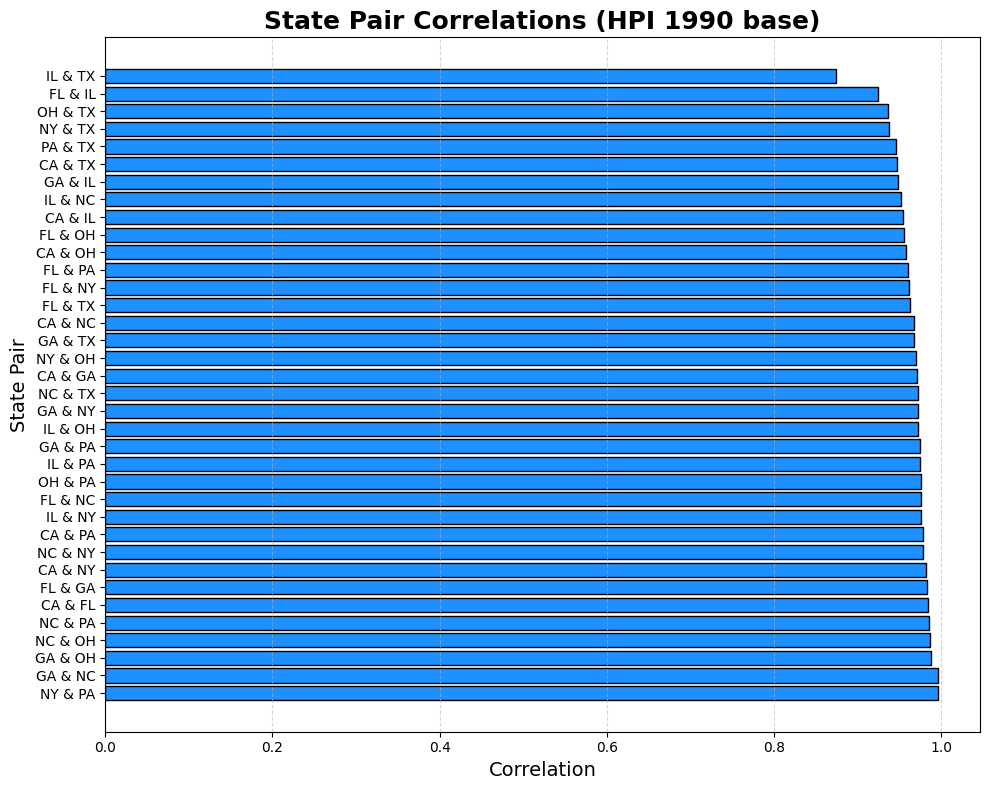

In [9]:
correlation_matrix.index.name = None
correlation_matrix.columns.name = None

# Prepare correlation pairs for plotting
corr_pairs = (
    correlation_matrix.stack()
    .reset_index()
    .rename(columns={'level_0': 'State1', 'level_1': 'State2', 0: 'Correlation'})
)

# Remove self-correlations
corr_pairs = corr_pairs[corr_pairs['State1'] != corr_pairs['State2']]

# Create a unique pair label (sorted so CA & TX and TX & CA are the same)
corr_pairs['Pair'] = corr_pairs.apply(
    lambda row: " & ".join(sorted([row['State1'], row['State2']])), axis=1
)

# Drop duplicate pairs
corr_pairs = corr_pairs.drop_duplicates(subset=['Pair'])

# Sort by correlation value
corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False)

# Bokeh bar chart
plt.figure(figsize=(10, 8))
plt.barh(
    corr_pairs['Pair'],
    corr_pairs['Correlation'],
    color="dodgerblue",
    edgecolor="black"
)
plt.xlabel("Correlation", fontsize=14)
plt.ylabel("State Pair", fontsize=14)
plt.title("State Pair Correlations (HPI 1990 base)", fontsize=18, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## House Price Index (HPI) Prediction and Model Evaluation 

### General function Structure 
 1. **Data Preparation**
 - X: Two predictor states are selected, and their HPI values are stored in X. For more accurate predictions, choose states that have a correlation value close to 1
 - y: Contains the set of HPI values for the target state
 - Rows with missing values are removed to ensure clean data to plot 
 2. **Training the model**
- Linear Regression: trains a linear regression model and predicts the HPIs for the target state 
- Ridge Regression: Similar to linear regression but adds regularization to prevent overfitting.
- Random Forest: Uses an ensemble of decision trees for prediction.
- Neural Network: Uses a multi-layer perceptron for regression.

3. **Classification metrics**
- y_class: actual movement (value of 1 if the HPI increased, 0 if it did not)
- y_pred_class: Predicted movement 

4. **Metrics calculated:**
- **Accuracy**: Proportion of correct predictions (both increases and decreases).
- **Precision**: Of all predicted increases, how many were actual increases.
- **Recall**: Of all actual increases, how many were correctly predicted.
- **F1 Score**: Harmonic mean of precision and recall, balancing both metrics.
- **Confusion Matrix**: Table showing counts of true positives, true negatives, false positives, and false negatives.
- **Classification Report**: Detailed summary of precision, recall, F1 score, and support (number of samples) for each class

5. **Visualization**
- Bokeh line chart: Plots actual vs predicted HPI values over time for the target state, allowing a visual comparison of model performance




In [10]:


# Pick two states with highest correlation to your target state (example: TX and FL to predict CA)


def linear_regression_predictor(target_state, predictor_states):
    # Prepare the data
    X = hpi_1990_key_states[predictor_states].values  # shape: (years, 2)
    y = hpi_1990_key_states[target_state].values      # shape: (years,)

    # Remove any rows with NaN values
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    years = hpi_1990_key_states.index[mask]

    # Train linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict HPI for the target state
    y_pred = model.predict(X)

      # Calculate classification metrics
    y_class = (np.diff(y, prepend=y[0]) > 0).astype(int)
    y_pred_class = (np.diff(y_pred, prepend=y_pred[0]) > 0).astype(int)
    
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    y_class = (np.diff(y, prepend=y[0]) > 0).astype(int)
    y_pred_class = (np.diff(y_pred, prepend=y_pred[0]) > 0).astype(int)

    # Calculate classification metrics
    print("Accuracy:", accuracy_score(y_class, y_pred_class))
    print("Precision:", precision_score(y_class, y_pred_class))
    print("Recall:", recall_score(y_class, y_pred_class))
    print("F1 Score:", f1_score(y_class, y_pred_class))
    print("Confusion Matrix:\n", confusion_matrix(y_class, y_pred_class))
    print("Classification Report:\n", classification_report(y_class, y_pred_class))

    # MATLAB-style plot
    plt.figure(figsize=(12, 7))
    plt.plot(years, y, label="Actual", color="blue", linewidth=2)
    plt.plot(years, y_pred, label="Predicted", color="red", linewidth=2, linestyle='--')
    plt.title(f"Linear Regression: Predicting {target_state} HPI using {predictor_states[0]} & {predictor_states[1]}", fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("House Price Index (1990 Base)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()

    




In [17]:


target_state = "TX"
predictor_states = ["CA", "NY"]

def random_forest_predictor(target_state, predictor_states):

    # Prepare the data
    X = hpi_1990_key_states[predictor_states].values
    y = hpi_1990_key_states[target_state].values

    # Remove any rows with NaN values
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    years = hpi_1990_key_states.index[mask]

    # Train Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=1)
    rf.fit(X, y)

    # Predict HPI for the target state
    y_pred = rf.predict(X)

    # Calculate accuracy metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    y_class = (np.diff(y, prepend=y[0]) > 0).astype(int)
    y_pred_class = (np.diff(y_pred, prepend=y_pred[0]) > 0).astype(int)

    # Calculate classification metrics
    print("Accuracy:", accuracy_score(y_class, y_pred_class))
    print("Precision:", precision_score(y_class, y_pred_class))
    print("Recall:", recall_score(y_class, y_pred_class))
    print("F1 Score:", f1_score(y_class, y_pred_class))
    print("Confusion Matrix:\n", confusion_matrix(y_class, y_pred_class))
    print("Classification Report:\n", classification_report(y_class, y_pred_class))

    # Plot actual vs predicted HPI

    plt.figure(figsize=(12, 7))
    plt.plot(years, y, label="Actual", color="blue", linewidth=2)
    plt.plot(years, y_pred, label="Predicted", color="red", linewidth=2, linestyle='--')
    plt.title(f"Random Forest: Predicting {target_state} HPI using {predictor_states[0]} & {predictor_states[1]}", fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("House Price Index (1990 Base)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()
    


In [15]:


def ridge_predictor(target_state, predictor_states):
    # Prepare the data
    X = hpi_1990_key_states[predictor_states].values
    y = hpi_1990_key_states[target_state].values

    # Remove any rows with NaN values
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    years = hpi_1990_key_states.index[mask]

    # Train Ridge regression model
    ridge = Ridge(alpha=1.0)
    ridge.fit(X, y)

    # Predict HPI for the target state
    y_pred = ridge.predict(X)

    # Regression metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Ridge Mean Squared Error: {mse:.2f}")
    print(f"Ridge R^2 Score: {r2:.2f}")

    # Convert to movement classes for classification metrics
    y_class = (np.diff(y, prepend=y[0]) > 0).astype(int)
    y_pred_class = (np.diff(y_pred, prepend=y_pred[0]) > 0).astype(int)

    print("Ridge Accuracy:", accuracy_score(y_class, y_pred_class))
    print("Ridge Precision:", precision_score(y_class, y_pred_class))
    print("Ridge Recall:", recall_score(y_class, y_pred_class))
    print("Ridge F1 Score:", f1_score(y_class, y_pred_class))
    print("Ridge Confusion Matrix:\n", confusion_matrix(y_class, y_pred_class))
    print("Ridge Classification Report:\n", classification_report(y_class, y_pred_class))

    # Plot actual vs predicted HPI
    
    plt.figure(figsize=(12, 7))
    plt.plot(years, y, label="Actual", color="blue", linewidth=2)
    plt.plot(years, y_pred, label="Predicted", color="orange", linewidth=2, linestyle='--')
    plt.title(f" Predicting {target_state} HPI using {predictor_states[0]} & {predictor_states[1]}", fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("House Price Index (1990 Base)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()
    



In [18]:
def neural_network_predictor(target_state, predictor_states):
    # Prepare the data
    X = hpi_1990_key_states[predictor_states].values
    y = hpi_1990_key_states[target_state].values

    # Remove any rows with NaN values
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    years = hpi_1990_key_states.index[mask]

    # Train neural network regressor
    nn = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=1)
    nn.fit(X, y)

    # Predict HPI for the target state
    y_pred = nn.predict(X)

    # Regression metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Neural Net Mean Squared Error: {mse:.2f}")
    print(f"Neural Net R^2 Score: {r2:.2f}")

    # Convert to movement classes for classification metrics
    y_class = (np.diff(y, prepend=y[0]) > 0).astype(int)
    y_pred_class = (np.diff(y_pred, prepend=y_pred[0]) > 0).astype(int)

    print("Neural Net Accuracy:", accuracy_score(y_class, y_pred_class))
    print("Neural Net Precision:", precision_score(y_class, y_pred_class))
    print("Neural Net Recall:", recall_score(y_class, y_pred_class))
    print("Neural Net F1 Score:", f1_score(y_class, y_pred_class))
    print("Neural Net Confusion Matrix:\n", confusion_matrix(y_class, y_pred_class))
    print("Neural Net Classification Report:\n", classification_report(y_class, y_pred_class))

    # Plot actual vs predicted HPI
  
    plt.figure(figsize=(12, 7))
    plt.plot(years, y, label="Actual", color="blue", linewidth=2)
    plt.plot(years, y_pred, label="Predicted", color="purple", linewidth=2, linestyle='--')
    plt.title(f"Neural Net: Predicting {target_state} HPI using {predictor_states[0]} & {predictor_states[1]}", fontsize=18, fontweight='bold')
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("House Price Index (1990 Base)", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()
    

Mean Squared Error: 263.77
R^2 Score: 0.92
Accuracy: 0.8
Precision: 0.9444444444444444
Recall: 0.8095238095238095
F1 Score: 0.8717948717948718
Confusion Matrix:
 [[ 6  2]
 [ 8 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.75      0.55         8
           1       0.94      0.81      0.87        42

    accuracy                           0.80        50
   macro avg       0.69      0.78      0.71        50
weighted avg       0.86      0.80      0.82        50



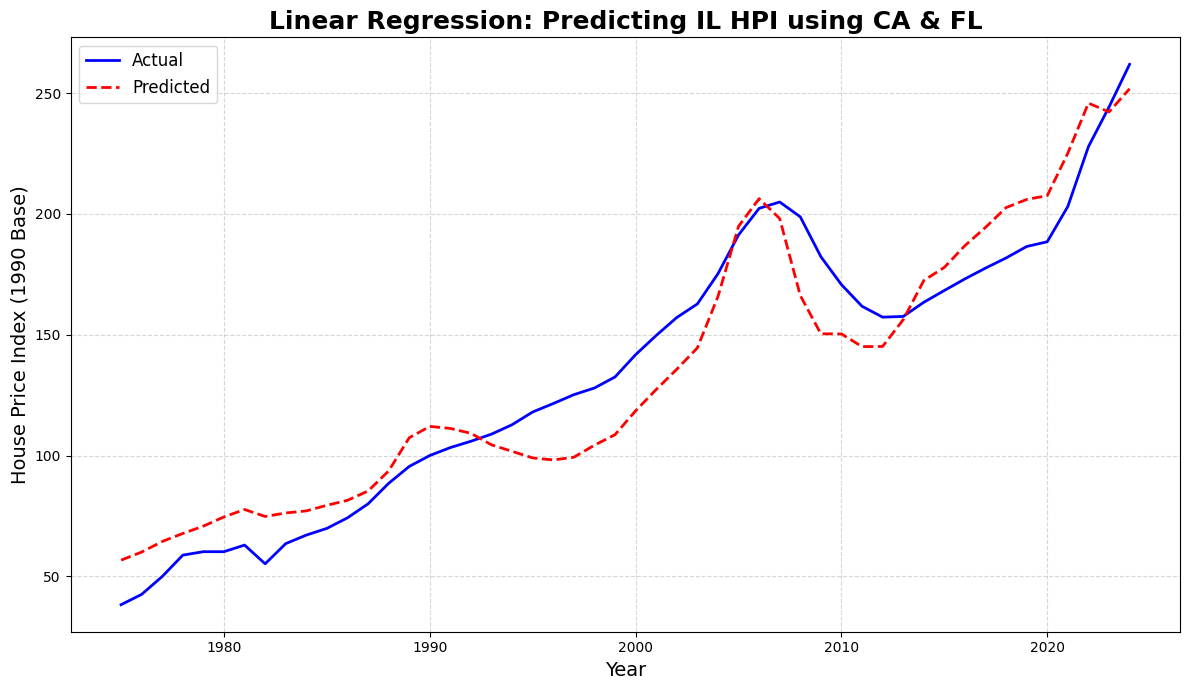

Ridge Mean Squared Error: 263.77
Ridge R^2 Score: 0.92
Ridge Accuracy: 0.8
Ridge Precision: 0.9444444444444444
Ridge Recall: 0.8095238095238095
Ridge F1 Score: 0.8717948717948718
Ridge Confusion Matrix:
 [[ 6  2]
 [ 8 34]]
Ridge Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.75      0.55         8
           1       0.94      0.81      0.87        42

    accuracy                           0.80        50
   macro avg       0.69      0.78      0.71        50
weighted avg       0.86      0.80      0.82        50



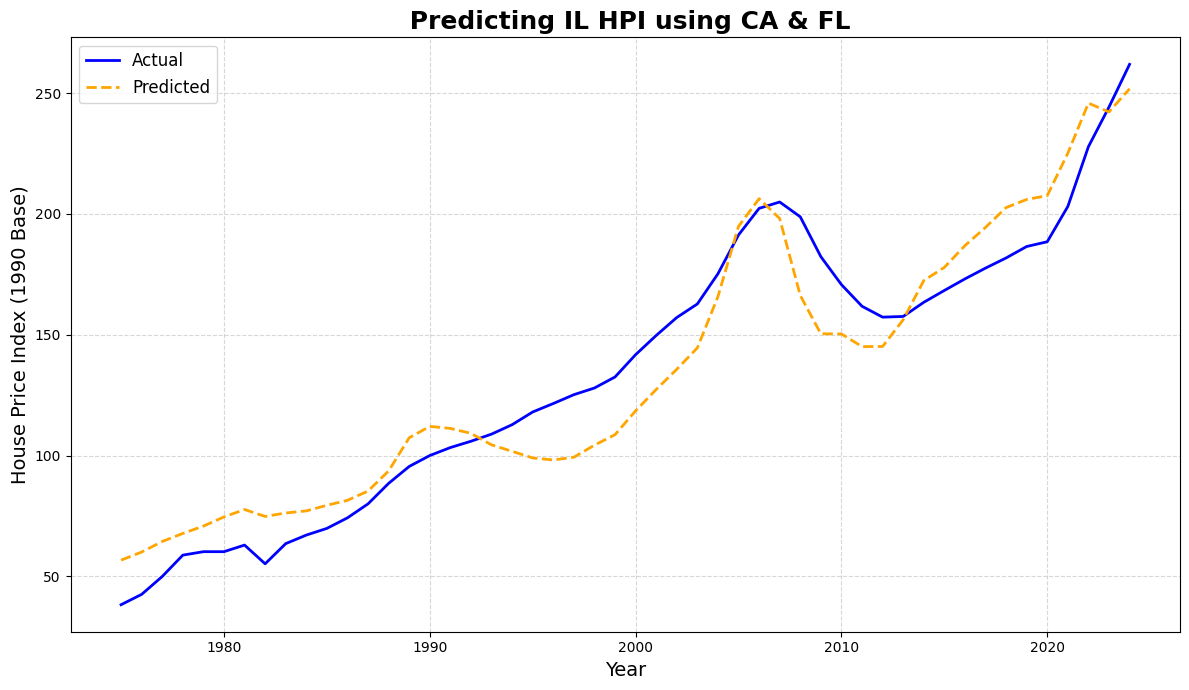

Mean Squared Error: 11.28
R^2 Score: 1.00
Accuracy: 0.98
Precision: 1.0
Recall: 0.9761904761904762
F1 Score: 0.9879518072289156
Confusion Matrix:
 [[ 8  0]
 [ 1 41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.98      0.99        42

    accuracy                           0.98        50
   macro avg       0.94      0.99      0.96        50
weighted avg       0.98      0.98      0.98        50



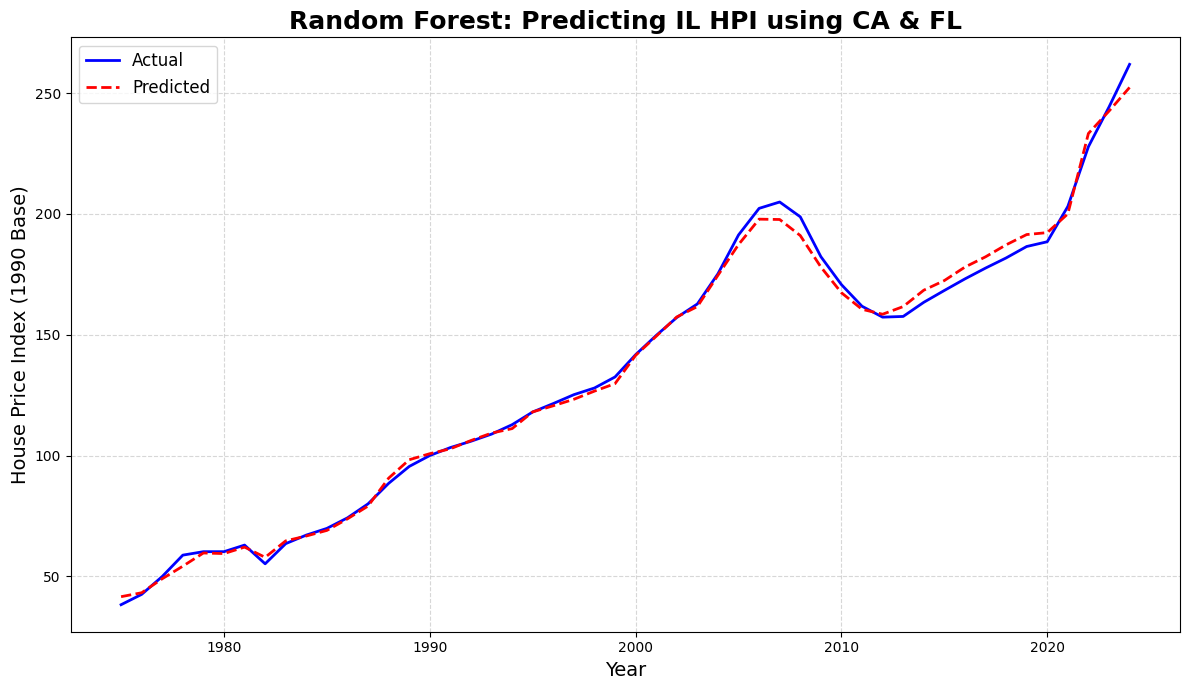

Neural Net Mean Squared Error: 1354.27
Neural Net R^2 Score: 0.58
Neural Net Accuracy: 0.88
Neural Net Precision: 0.9736842105263158
Neural Net Recall: 0.8809523809523809
Neural Net F1 Score: 0.925
Neural Net Confusion Matrix:
 [[ 7  1]
 [ 5 37]]
Neural Net Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.88      0.70         8
           1       0.97      0.88      0.93        42

    accuracy                           0.88        50
   macro avg       0.78      0.88      0.81        50
weighted avg       0.91      0.88      0.89        50



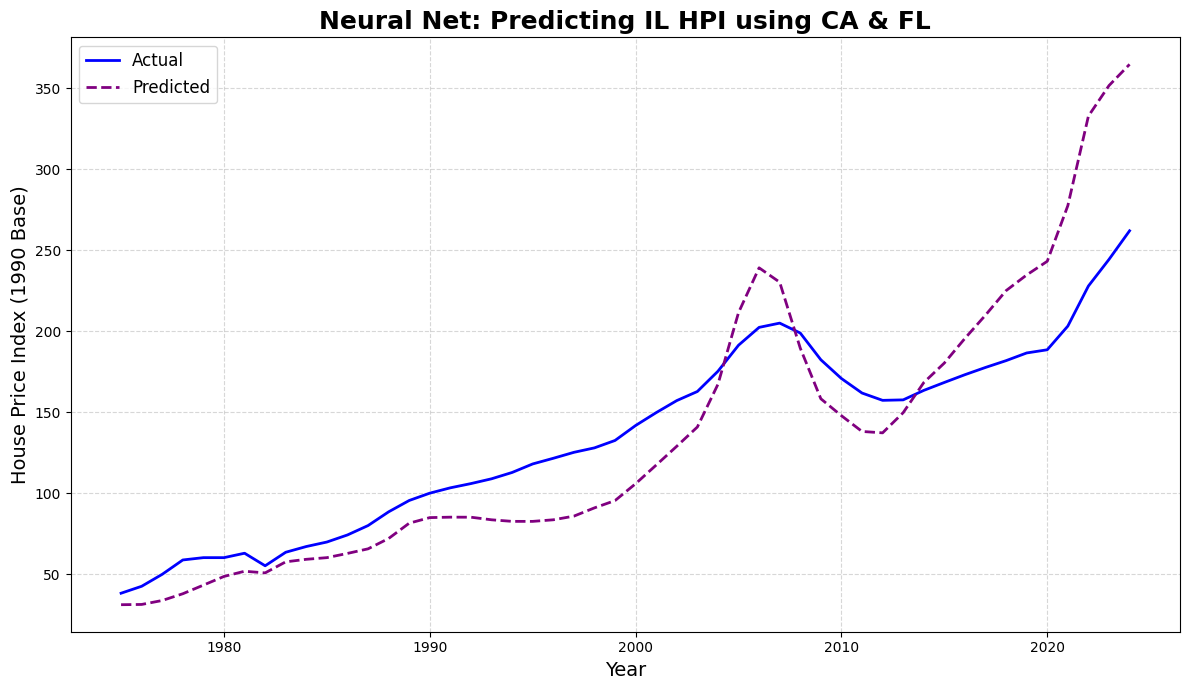

In [19]:
target_state = "IL"
predictor_states = ["CA", "FL"]

linear_regression_predictor(target_state, predictor_states)
ridge_predictor(target_state, predictor_states)
random_forest_predictor(target_state, predictor_states)
neural_network_predictor(target_state, predictor_states)